# Select aviso datacube

(Utiliser l'environnement *data-env*)

L'objectif est d'extraire des cubes de données autour d'un ensemble de points d'observations à partir d'un datacube (time, lon, lat).

## Configuration

### Librairies

In [1]:
import sys
import time
from pathlib import Path
from datetime import datetime, timedelta

import intake
import numpy as np
import pandas as pd
import xarray as xr
from dask.distributed import LocalCluster, Client
from IPython.display import display

sys.path.insert(0, '../..')
from histlib.observations import (
    generate_virtual_observations,
    plot_observations,
)

In [2]:
import warnings
warnings.filterwarnings('ignore')

## Observations

In [10]:
N = 100 # Nombre de points d'observations
extent = (-180, 180, -90, 90) # Extension spatiale (lon_min, lon_max, lat_min, lat_max)
period = ('2000-01-01', '2001-01-01') # Extension temporelle (start_date, end_date)

In [11]:
# Génération des points d'observations
ds = generate_virtual_observations(N, extent, period)

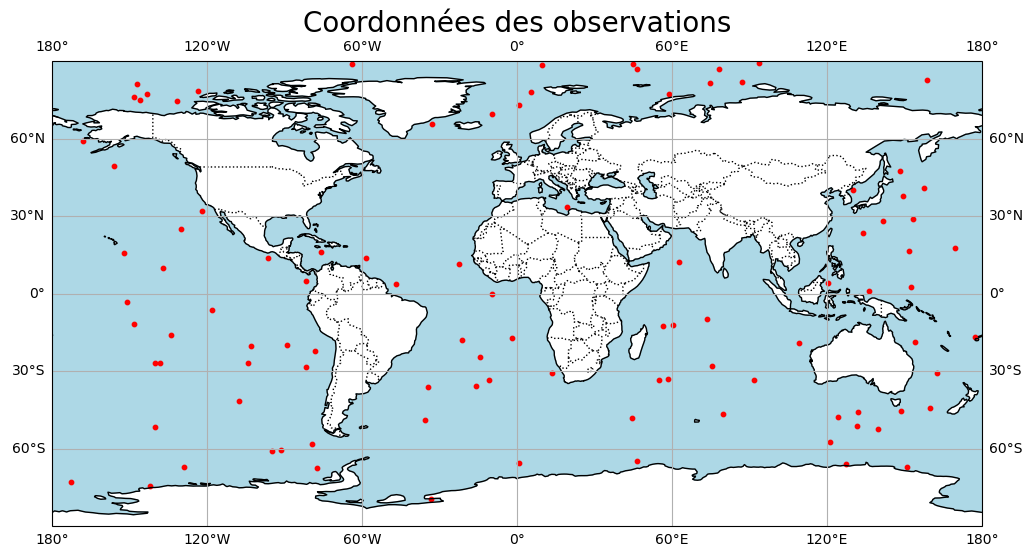

In [12]:
# Affichage sur une carte
plot_observations(ds)

## Datacube

In [3]:
dataset = 'aviso' # Nom du jeu de données (aviso / erastar)
name = 'datacube' # Nom du datacube

In [4]:
# Définir la taille des chunks
chunks = dict(time=1, lat=-1, lon=-1)

In [5]:
_drop = [
    "crs",
    "lat_bnds",
    "lon_bnds",
    "ugosa",
    "err_ugosa",
    "vgosa",
    "err_vgosa",
    "ugos",
    "vgos",
    "flag_ice",
    "tpa_correction",
    "nv",
]

In [6]:
%%time
# Chargement du datacube
WRK = Path(f'/home1/datawork/gcaer/data/{dataset}/{name}')
cat = intake.open_catalog(WRK / f"references/aviso/reference.yaml")
datacube = cat["data"](chunks={"time": chunks['time'], "latitude": chunks['lat'], "longitude": chunks['lon']}).to_dask().drop_vars(_drop)

CPU times: user 3min 14s, sys: 19 s, total: 3min 33s
Wall time: 3min 42s


In [7]:
datacube

<xarray.Dataset>
Dimensions:    (time: 11115, latitude: 720, longitude: 1440)
Coordinates:
  * latitude   (latitude) float32 -89.88 -89.62 -89.38 ... 89.38 89.62 89.88
  * longitude  (longitude) float32 -179.9 -179.6 -179.4 ... 179.4 179.6 179.9
  * time       (time) datetime64[ns] 1993-01-01 1993-01-02 ... 2023-06-07
Data variables:
    adt        (time, latitude, longitude) float64 dask.array<chunksize=(1, 720, 1440), meta=np.ndarray>
    err_sla    (time, latitude, longitude) float64 dask.array<chunksize=(1, 720, 1440), meta=np.ndarray>
    sla        (time, latitude, longitude) float64 dask.array<chunksize=(1, 720, 1440), meta=np.ndarray>
Attributes: (12/44)
    Conventions:                     CF-1.6
    Metadata_Conventions:            Unidata Dataset Discovery v1.0
    cdm_data_type:                   Grid
    comment:                         Sea Surface Height measured by Altimetry...
    contact:                         servicedesk.cmems@mercator-ocean.eu
    creator_email:                   servicedesk.cmems@mercator-ocean.eu
    ...                              ...
    summary:                         SSALTO/DUACS Delayed-Time Level-4 sea su...
    time_coverage_duration:          P1D
    time_coverage_end:               1993-01-01T12:00:00Z
    time_coverage_resolution:        P1D
    time_coverage_start:             1992-12-31T12:00:00Z
    title:                           DT merged all satellites Global Ocean Gr...

In [17]:
ds.obs.values

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
       68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84,
       85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99])

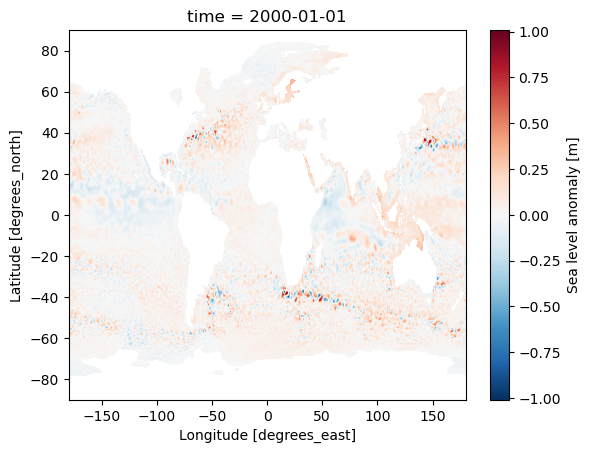

In [10]:
datacube.isel(time=0).sla.plot()

## Select points

Avant de sélectionner des cubes on commence par sélectionner les valeurs les plus proches des points d'observations. 

In [11]:
# Selection dans le datacube
result = datacube.sel(
    time=ds.time,
    longitude=ds.lon,
    latitude=ds.lat,
    method="nearest",
)

## Select cubes

Ici, on parcours les observations les unes après les autres en selectionnant le cube au sein du datacube.

In [10]:
# Définition des paramètres
dt, dlon, dlat = 2, 5, 5 # +/- dt jours, +/- dlon° de longitude, +/- dlat° de latitude
dl = 0.25 # le pas spatial (entre 2 valeurs de longitude)

### 1) Séquentielle

Ici, on parcours les observations les unes après les autres en selectionnant le cube au sein du datacube.

In [14]:
%%time
results = []
for idx, obs in enumerate(ds.obs):
    
    display(f"{idx}/{len(ds.obs)}", clear=True)
    
    start, end = obs.time + pd.Timedelta(days=-dt), obs.time + pd.Timedelta(days=dt)
    lon_min, lon_max = obs.lon - dlon, obs.lon + dlon
    lat_min, lat_max = obs.lat - dlat, obs.lat + dlat
    
    # Sélection d'un cube au sein du datacube
    results.append(
        datacube.sel(
            time=slice(start,end),
            longitude=slice(lon_min, lon_max),
            latitude=slice(lat_min, lat_max),
        ).compute()
    )

'9/10'

CPU times: user 3.99 s, sys: 2.5 s, total: 6.48 s
Wall time: 19.2 s


### 2) Vectorielle

Ici, on selectionne les cubes de chaque observations en une seul fois, *(/!\ Ce sont des cubes de même tailles)*

#### a) Same shape cubes (2D arrays)

In [20]:
# Définition des paramètres
dt, dlon, dlat = 2, 5, 5 # +/- dt jours, +/- dlon° de longitude, +/- dlat° de latitude

In [21]:
%%time
dt= (-2, 3)
dl = 0.25
TIME, LON, LAT = [], [] ,[]
for idx, obs in enumerate(ds.obs):
    
    lon_min, lon_max = obs.lon - dlon, obs.lon + dlon
    lat_min, lat_max = obs.lat - dlat, obs.lat + dlat

    LON.append(np.r_[slice(lon_min, lon_max, dl)])
    LAT.append(np.r_[slice(lat_min, lat_max, dl)])
    TIME.append([obs.time.values + pd.Timedelta(days=_dt) for _dt in range(*dt)])

CPU times: user 56 ms, sys: 0 ns, total: 56 ms
Wall time: 54.9 ms


In [22]:
%%time
result = datacube.sel(
    time=xr.DataArray(TIME,  dims=["obs","t"]),
    longitude=xr.DataArray(LON,  dims=["obs","x"]),
    latitude=xr.DataArray(LAT,  dims=["obs","y"]),
    method="nearest",
).compute()

CPU times: user 6.68 s, sys: 3.76 s, total: 10.4 s
Wall time: 19.2 s


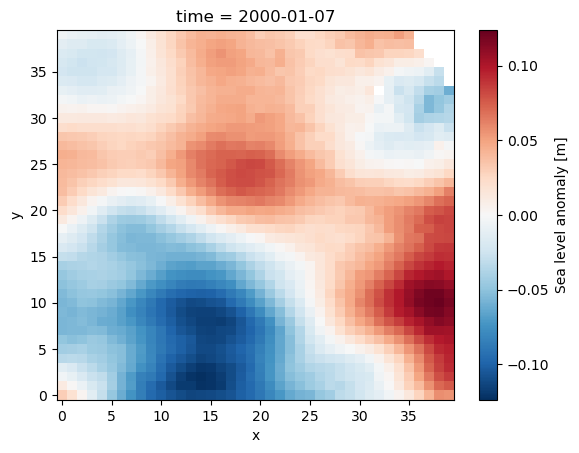

In [34]:
result.isel(obs=0, t=0).sla.plot()

#### b) Different shape cubes (1D flatten arrays)

In [11]:
%%time
# Génération des slices des cubes à partir des observations
s_time, s_lat, s_lon = [], [] , []
for idx, obs in enumerate(ds.obs):
    
    #display(f"{idx+1}/{len(ds.obs)}", clear=True)
    
    start, end = obs.time + pd.Timedelta(days=-dt), obs.time + pd.Timedelta(days=dt)
    lon_min, lon_max = obs.lon - dlon, obs.lon + dlon
    lat_min, lat_max = obs.lat - dlat, obs.lat + dlat
    
    s_time.append(slice(start.values, end.values + pd.Timedelta(days=1), timedelta(days=1)))
    s_lat.append(slice(lat_min, lat_max, dl))
    s_lon.append(slice(lon_min, lon_max, dl))

CPU times: user 28 ms, sys: 0 ns, total: 28 ms
Wall time: 38.6 ms


In [12]:
%%time
# Génération des listes d'indices à plat à partir des slices
f_time, f_lat, f_lon = [], [], []
pos, shapes = [], []
n=0
for st, sla, slo in zip(s_time, s_lat, s_lon):
    
    # Générer les indices pour chaque dimension de l'observation en cours
    it = np.r_[st]
    ila = np.r_[sla]
    ilo = np.r_[slo]

    # Créer des grilles multidimensionnelles
    gt, gla, glo = np.meshgrid(it, ila, ilo, indexing='ij')

    # Mise à plat des indices
    ft = gt.flatten()
    fla = gla.flatten()
    flo = glo.flatten()

    # Ajouter les indices à plat du cube, dans la liste des indices à plat
    f_time.extend(ft)
    f_lat.extend(fla)
    f_lon.extend(flo)

    # Enregistre la dimension du cube
    shapes.append((len(it), len(ila), len(ilo)))
    
    # Enregistre les indices correspondant au cube
    n1 = n + len(ft)
    pos.append(slice(n, n1))       
    n = n1

CPU times: user 60 ms, sys: 8 ms, total: 68 ms
Wall time: 65.3 ms


In [13]:
%%time
# Sélection dans le datacube
result = datacube.sel(
    time=xr.DataArray(f_time,  dims="points"),
    longitude=xr.DataArray(f_lon,  dims="points"),
    latitude=xr.DataArray(f_lat,  dims="points"),
    method="nearest",
).compute()

CPU times: user 11.8 s, sys: 4.12 s, total: 15.9 s
Wall time: 49.2 s


In [17]:
result

<xarray.Dataset>
Dimensions:         (points: 80000, nv: 2)
Coordinates:
    latitude        (points) float32 75.12 75.12 75.12 ... 44.62 44.62 44.62
    longitude       (points) float32 44.38 44.62 44.88 ... -56.38 -56.12 -55.88
  * nv              (nv) int32 0 1
    time            (points) datetime64[ns] 2000-03-26 2000-03-26 ... 2000-01-26
Dimensions without coordinates: points
Data variables: (12/14)
    adt             (points) float64 dask.array<chunksize=(80000,), meta=np.ndarray>
    crs             (points) float64 dask.array<chunksize=(8000,), meta=np.ndarray>
    err_sla         (points) float64 dask.array<chunksize=(80000,), meta=np.ndarray>
    err_ugosa       (points) float64 dask.array<chunksize=(80000,), meta=np.ndarray>
    err_vgosa       (points) float64 dask.array<chunksize=(80000,), meta=np.ndarray>
    flag_ice        (points) float64 dask.array<chunksize=(80000,), meta=np.ndarray>
    ...              ...
    sla             (points) float64 dask.array<chunksize=(80000,), meta=np.ndarray>
    tpa_correction  (points) float64 dask.array<chunksize=(8000,), meta=np.ndarray>
    ugos            (points) float64 dask.array<chunksize=(80000,), meta=np.ndarray>
    ugosa           (points) float64 dask.array<chunksize=(80000,), meta=np.ndarray>
    vgos            (points) float64 dask.array<chunksize=(80000,), meta=np.ndarray>
    vgosa           (points) float64 dask.array<chunksize=(80000,), meta=np.ndarray>
Attributes: (12/44)
    Conventions:                     CF-1.6
    Metadata_Conventions:            Unidata Dataset Discovery v1.0
    cdm_data_type:                   Grid
    comment:                         Sea Surface Height measured by Altimetry...
    contact:                         servicedesk.cmems@mercator-ocean.eu
    creator_email:                   servicedesk.cmems@mercator-ocean.eu
    ...                              ...
    summary:                         SSALTO/DUACS Delayed-Time Level-4 sea su...
    time_coverage_duration:          P1D
    time_coverage_end:               2000-01-01T12:00:00Z
    time_coverage_resolution:        P1D
    time_coverage_start:             1999-12-31T12:00:00Z
    title:                           DT merged all satellites Global Ocean Gr...

In [27]:
%%time
# A partir de la liste unique on récupère les listes de valeurs de chaque observation
arrs = []
for p in pos:
    arrs.append(result.sel(points=p))

CPU times: user 28 ms, sys: 0 ns, total: 28 ms
Wall time: 27.2 ms


In [29]:
%%time
# Pour chaque cube on remet en forme le cube
results = []
for idx, (arr, shape) in enumerate(zip(arrs, shapes)):
    dsa_time = np.r_[s_time[idx]]
    dsa_lat = np.r_[s_lat[idx]]
    dsa_lon = np.r_[s_lon[idx]]
    dsa_data = arr.adt.values.reshape(shape)
    results.append(xr.Dataset(
            data_vars=dict(adt=(['time', 'lat', 'lon'], dsa_data)),
            coords=dict(
                lat=dsa_lat,
                lon=dsa_lon,
                time=dsa_time,
            )
        )
    )

CPU times: user 56 ms, sys: 0 ns, total: 56 ms
Wall time: 56.9 ms


#### b) Different shape cubes (1D flatten arrays) with map_blocks

In [12]:
conf = (2, 5, 5)

In [84]:
def flatten(ds, datacube, conf):
    """Colocalisation with a flatten method"""
    dt, dx, dy = conf
    f_t, f_x, f_y = [], [], []
    for obs in ds.obs:

        start, end = obs.time + pd.Timedelta(days=-dt), obs.time + pd.Timedelta(days=dt+1)
        x_min, x_max = obs.lon - dx, obs.lon + dx
        y_min, y_max = obs.lat - dy, obs.lat + dy

        s_t = slice(start.values, end.values, timedelta(days=1))
        s_x = slice(x_min, x_max)
        s_y = slice(y_min, y_max)

        # Générer les indices
        it, ix, iy = np.r_[s_t], np.r_[s_x], np.r_[s_y]

        # Créer des grilles multidimensionnelles
        gt, gx, gy = np.meshgrid(it, ix, iy, indexing='ij')

        # Mise à plat des indices
        ft, fx, fy = gt.flatten(), gx.flatten(), gy.flatten()

        # Ajouter les indices à plat du cube, dans la liste des indices à plat
        f_t.extend(ft)
        f_x.extend(fx)
        f_y.extend(fy)
    
    return datacube.sel(
        time=xr.DataArray(f_t,  dims="points"),
        longitude=xr.DataArray(f_x,  dims="points"),
        latitude=xr.DataArray(f_y,  dims="points"),
        method="nearest",
    ).compute()

In [60]:
ds

<xarray.Dataset>
Dimensions:  (obs: 10)
Coordinates:
  * obs      (obs) int64 0 1 2 3 4 5 6 7 8 9
    lat      (obs) float64 -35.54 -0.4844 32.99 75.01 ... 45.28 -41.71 -41.31
    lon      (obs) float64 -169.9 -117.4 -124.5 -152.2 ... -12.86 -6.879 -78.23
    time     (obs) datetime64[ns] 2000-06-29 2000-12-24 ... 2000-04-16
Data variables:
    *empty*

In [93]:
dsc = ds.chunk()

In [94]:
%%time
res = flatten(ds, datacube, conf)

CPU times: user 4.18 s, sys: 312 ms, total: 4.5 s
Wall time: 28 s


In [86]:
cluster = LocalCluster()
client = Client(cluster)
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 4
Total threads: 4,Total memory: 16.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:50679,Workers: 4
Dashboard: http://127.0.0.1:8787/status,Total threads: 4
Started: Just now,Total memory: 16.00 GiB
Comm: tcp://127.0.0.1:38622,Total threads: 1
Dashboard: http://127.0.0.1:34512/status,Memory: 4.00 GiB
Nanny: tcp://127.0.0.1:34948,


In [95]:
%%time
res = flatten(dsc, datacube, conf)

CPU times: user 19.8 s, sys: 1.5 s, total: 21.3 s
Wall time: 1min 12s


In [ ]:
res